In [1]:
# Libraries import
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import plotly.graph_objs as go
#import plotly.express as px
from plotly.offline import init_notebook_mode

from bokeh.plotting import figure, show, output_file, ColumnDataSource
from bokeh.models import HoverTool, GeoJSONDataSource, LinearColorMapper

from googletrans import Translator

#import statsmodels.api as sn

import requests
import json

In [2]:
# Data import - 'Datos abiertos COVID-19 (Colombia)'
data = pd.DataFrame.from_dict(requests.get('https://www.datos.gov.co/resource/gt2j-8ykr.json?$limit=9999999999999').json())
#data

In [3]:
# Data import - 'World Health Organization (WHO) COVID-19 Global Data'
who_data = pd.read_csv('https://covid19.who.int/WHO-COVID-19-global-data.csv')
#who_data

In [4]:
# Data import - 'Colombian Departments GeoJson'
d_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/43c7656821069d00dcbc/raw/be6a6e239cd5b5b803c6e7c2ec405b793a9064dd/Colombia.geo.json').json()
#d_geojson

In [5]:
# Data import - 'Colombian Towns & Cities GeoJson'
tc_geojson = requests.get('https://gist.githubusercontent.com/john-guerra/727e8992e9599b9d9f1dbfdc4c8e479e/raw/090f8b935a437e24d65b64d87598fbb437c006da/colombia-municipios.json').json()
#tc_geojson

In [6]:
# Data cleaning and adjusting
translator = Translator()
translations = {}

departments = {}
towns_cities = {}
status_counts = []

data.columns = ['Id de caso', 'Fecha de notificación', 'Código DIVIPOLA', 'Ciudad de ubicación', 'Departamento', 'Estado', 'Edad', 'Sexo', 'Tipo', 'Severidad','País de procedencia', 'Fecha de inicio de síntomas', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web', 'Tipo de recuperación', 'Código departamento', 'Código país', 'Pertenencia étnica', 'Ubicación recuperado', 'Nombre grupo étnico', 'Fecha de defunción']
#who_data.columns = ['']

for element in data['País de procedencia'].unique():
    translations[element] = translator.translate(" ".join(element.split(" ")[:2])).text if type(element) !=  float else 'Colombia'

data['País de procedencia'].replace(translations, inplace=True)

for column in ['Edad', 'Código departamento', 'Código DIVIPOLA']:
    data[column] = data[column].apply(lambda x: int(x))
    
data['Clasificación de edad'] = pd.cut(x=data['Edad'], bins=[0,10,20,30,40,50,60,70,80,90,np.inf], include_lowest=True, labels=['0 - 10', '10 - 20', '20 - 30', '30 - 40', '40 - 50', '50 - 60', '60 - 70', '70 - 80', '80 - 90', '90 - 100+'])

for column in ['Ciudad de ubicación', 'Estado', 'Sexo', 'Tipo', 'Severidad', 'País de procedencia', 'Ubicación recuperado']:
    data[column] = data[column].str.capitalize()
    
for column in ['Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de defunción', 'Fecha de diagnóstico', 'Fecha de recuperación', 'Fecha de reporte web']:
    data[column] = data[column].str.slice(0,10).replace(r'(\d+)-(\d+)-(\d+)', r'\1-\2-\3', regex=True).apply(lambda x: pd.to_datetime(x, dayfirst=True, errors='ignore'))

for element in d_geojson['features']:
    departments[int(element['properties']['DPTO'])] = element['properties']['NOMBRE_DPT']
    
#for element in tc_geojson['geometries']:
#    towns_cities[int(element['id'])] = element['properties']['name']
    
status_counts = data['Estado'].value_counts().to_list()

date = data['Fecha de reporte web'].iloc[-1].strftime('%Y-%m-%d')
    
data = data[['Id de caso', 'Fecha de reporte web', 'Fecha de diagnóstico', 'Fecha de notificación', 'Fecha de inicio de síntomas', 'Fecha de recuperación', 'Fecha de defunción', 'Severidad', 'Estado', 'Tipo', 'Tipo de recuperación', 'Ubicación recuperado', 'Ciudad de ubicación', 'Departamento', 'País de procedencia', 'Edad', 'Clasificación de edad', 'Sexo', 'Pertenencia étnica', 'Nombre grupo étnico', 'Código departamento', 'Código país', 'Código DIVIPOLA']]
data = data.set_index('Id de caso')

In [7]:
# Helper functions
def GetBars(df):
    d = df.to_dict('list')
    #for i in range(df[]):

def numbers(div): #x
    for i in range(0, len(ax.patches)//div, 1):
        height = 0
        for j in range(0, div, 1):
            height += ax.patches[j*(len(ax.patches)//div)+i].get_height()
        ax.text(ax.patches[i].get_x()+(ax.patches[i].get_width()/10),height+(height/100)+10, int(height), fontsize=8, color='darkgray', rotation=90)

def numbers_H(div): #y
    for i in range(0, len(ax.patches)//div, 1):
        width = 0
        for j in range(0, div, 1):
            width += ax.patches[j*(len(ax.patches)//div)+i].get_width()
        ax.text(width+(width/100)+10,ax.patches[i].get_y()+(ax.patches[i].get_height()/10), int(width), fontsize=8, color='darkgray', rotation=0)

In [8]:
# Testing
#bars = GetBars()

bar_chart = go.Figure(
    data = go.Histogram(
        
    ),
    layout = go.Layout(
        title="Casos confirmados VS Clasificación de Edad (Estado)",
        yaxis_title="Clasificación de edad",
        xaxis_title="Casos confirmados",
    )
)
#bar_chart.show()

#data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).to_dict('list')

In [9]:
# In-line plots libraries import
%matplotlib inline
init_notebook_mode(connected = True)

# COVID-19 Status (Colombia) 🇨🇴

#### Fuente: <a href='https://datos.gov.co'>Datos Abiertos - Colombia</a>

### - Panorama nacional COVID-19 (Colombia)

In [10]:
local_map = go.Figure(go.Choropleth(
    z=data['Código departamento'].value_counts().sort_index().tolist(),
    locations=[departments[key] for key in sorted(departments.keys())],
    featureidkey='properties.NOMBRE_DPT',
    geojson=d_geojson,
    colorscale='blues',
    colorbar_title="Casos confirmados COVID-19",
    autocolorscale = False,
    reversescale = True,
    marker_line_color='darkgray',
    marker_line_width=0.5,
))

local_map.update_geos(showcountries=False, showcoastlines=False, showland=False, fitbounds='locations')

local_map.update_layout(
    margin={"r":0,"t":0,"l":0,"b":0},
    geo = dict(
        showframe = False,
        showcoastlines = False,
        projection_type = 'equirectangular'
    ),
    annotations = [
        dict(
            x=0,
            y=0.25,
            xref='paper',
            yref='paper',
            text= f' - Colombia - ',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.18,
            xref='paper',
            yref='paper',
            text= f'Casos confirmados: {len(data.index):,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.15,
            xref='paper',
            yref='paper',
            text= f'Casos activos: {status_counts[1]+status_counts[2]+status_counts[4]+status_counts[5]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.12,
            xref='paper',
            yref='paper',
            text= f'Recuperados: {status_counts[0]:,} - Fallecidos: {status_counts[3]:,}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.08,
            xref='paper',
            yref='paper',
            text= f'Fecha: {date}',
            showarrow = False
        ),
        dict(
            x=0,
            y=0.05,
            xref='paper',
            yref='paper',
            text='Fuente: <a href="https://datos.gov.co">Datos Abiertos - Colombia</a>',
            showarrow = False
        ),
    ]
)

local_map.show()

### - Dataset COVID-19 (Colombia)

In [11]:
data

Fecha de reporte web Fecha de diagnóstico Fecha de notificación  \
Id de caso                                                                   
1                    2020-03-06           2020-03-06            2020-03-02   
2                    2020-03-09           2020-03-09            2020-03-06   
3                    2020-03-09           2020-03-09            2020-03-07   
4                    2020-03-11           2020-03-11            2020-03-09   
5                    2020-03-11           2020-03-11            2020-03-09   
...                         ...                  ...                   ...   
848183               2020-10-03           2020-10-01            2020-09-28   
848184               2020-10-03           2020-10-01            2020-10-01   
848185               2020-10-03           2020-10-01            2020-10-01   
848186               2020-10-03           2020-09-18            2020-09-16   
848187               2020-10-03           2020-09-18            2020-09-16   

           Fecha de inicio de síntomas Fecha de recuperación  \
Id de caso                                                     
1                           2020-02-27            2020-03-13   
2                           2020-03-04            2020-03-19   
3                           2020-02-29            2020-03-15   
4                           2020-03-06            2020-03-26   
5                           2020-03-08            2020-03-23   
...                                ...                   ...   
848183                      2020-09-26                   NaT   
848184                      2020-09-25                   NaT   
848185                      2020-09-24                   NaT   
848186                      2020-09-15                   NaT   
848187                      2020-09-13                   NaT   

           Fecha de defunción Severidad      Estado         Tipo  \
Id de caso                                                         
1                         NaT      Leve  Recuperado    Importado   
2                         NaT      Leve  Recuperado    Importado   
3                         NaT      Leve  Recuperado    Importado   
4                         NaT      Leve  Recuperado  Relacionado   
5                         NaT      Leve  Recuperado  Relacionado   
...                       ...       ...         ...          ...   
848183                    NaT      Leve        Casa   En estudio   
848184                    NaT      Leve        Casa   En estudio   
848185                    NaT      Leve        Casa   En estudio   
848186                    NaT      Leve        Casa   En estudio   
848187                    NaT  Moderado    Hospital   En estudio   

           Tipo de recuperación  ...     Departamento País de procedencia  \
Id de caso                       ...                                        
1                           PCR  ...      Bogotá D.C.               Italy   
2                           PCR  ...  Valle del Cauca               Spain   
3                           PCR  ...        Antioquia               Spain   
4                           PCR  ...        Antioquia            Colombia   
5                           PCR  ...        Antioquia            Colombia   
...                         ...  ...              ...                 ...   
848183                      NaN  ...      Bogotá D.C.            Colombia   
848184                      NaN  ...      Bogotá D.C.            Colombia   
848185                      NaN  ...      Bogotá D.C.            Colombia   
848186                      NaN  ...      Bogotá D.C.            Colombia   
848187                      NaN  ...      Bogotá D.C.            Colombia   

           Edad Clasificación de edad  Sexo Pertenencia étnica  \
Id de caso                                                       
1            19               10 - 20     F               Otro   
2            34               30 - 40     M              Negro   
3           

### - TOP 50: Casos activos VS Ciudad de ubicación (Estado)

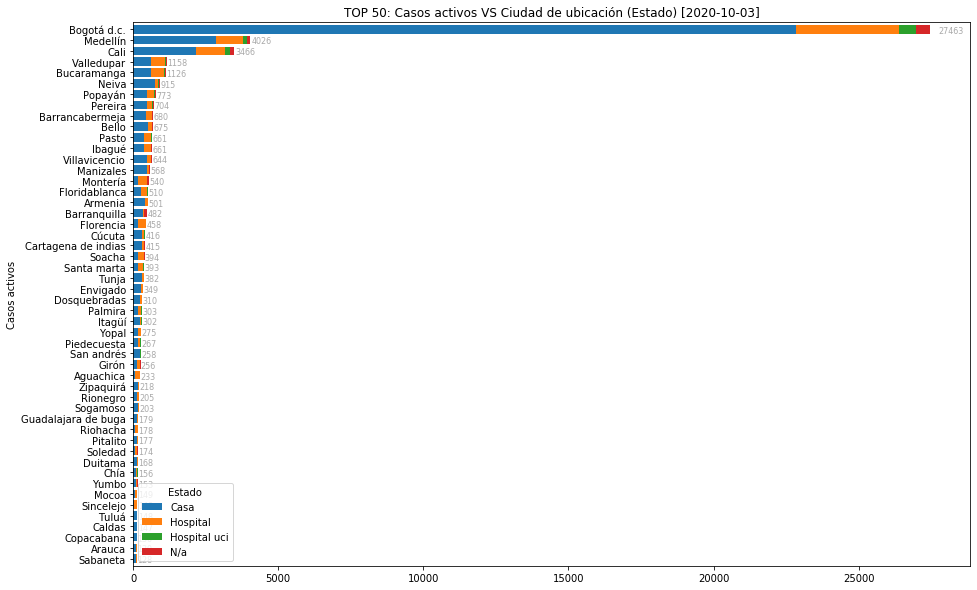

In [12]:
li = data.groupby(['Ciudad de ubicación', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').tail(50).iloc[:,:len(li.columns)-1].plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'TOP 50: Casos activos VS Ciudad de ubicación (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers_H(div)

In [13]:
li.sort_values('Total', ascending=False).head(50)

Estado                  Casa  Hospital  Hospital uci    N/a    Total
Ciudad de ubicación                                                 
Bogotá d.c.          22835.0    3544.0         589.0  495.0  27463.0
Medellín              2863.0     914.0         150.0   99.0   4026.0
Cali                  2177.0     995.0         169.0  125.0   3466.0
Valledupar             601.0     499.0          36.0   22.0   1158.0
Bucaramanga            604.0     459.0          36.0   27.0   1126.0
Neiva                  771.0      80.0          54.0   10.0    915.0
Popayán                472.0     252.0          31.0   18.0    773.0
Pereira                493.0     162.0          39.0   10.0    704.0
Barrancabermeja        437.0     214.0          17.0   12.0    680.0
Bello                  516.0     130.0          17.0   12.0    675.0
Pasto                  364.0     256.0          22.0   19.0    661.0
Ibagué                 371.0     247.0          15.0   28.0    661.0
Villavicencio          472.0     143.0          11.0   18.0    644.0
Manizales              488.0      64.0           4.0   12.0    568.0
Montería               177.0     299.0           7.0   57.0    540.0
Floridablanca          278.0     213.0          13.0    6.0    510.0
Armenia                427.0      72.0           1.0    1.0    501.0
Barranquilla           339.0      21.0           0.0  122.0    482.0
Florencia              168.0     265.0           9.0   16.0    458.0
Cúcuta                 291.0      81.0          30.0   14.0    416.0
Cartagena de indias    300.0      64.0          11.0   40.0    415.0
Soacha                 184.0     187.0          13.0   10.0    394.0
Santa marta            156.0     200.0          12.0   25.0    393.0
Tunja                  298.0      74.0           4.0    6.0    382.0
Envigado               266.0      67.0          11.0    5.0    349.0
Dosquebradas           227.0      69.0          10.0    4.0    310.0
Palmira                164.0     117.0          12.0   10.0    303.0
Itagüí                 226.0      61.0           7.0    8.0    302.0
Yopal                  181.0      85.0           8.0    1.0    275.0
Piedecuesta            163.0      92.0          10.0    2.0    267.0
San andrés             225.0      28.0           3.0    2.0    258.0
Girón                  138.0     106.0           5.0    7.0    256.0
Aguachica               56.0     168.0           8.0    1.0    233.0
Zipaquirá              184.0      25.0           5.0    4.0    218.0
Rionegro               147.0      51.0           4.0    3.0    205.0
Sogamoso               157.0      43.0           1.0    2.0    203.0
Guadalajara de buga    126.0      48.0           2.0    3.0    179.0
Riohacha                74.0      94.0           4.0    6.0    178.0
Pitalito               118.0      43.0          11.0    5.0    177.0
Soledad                 69.0      54.0           6.0   45.0    174.0
Duitama                124.0      39.0           1.0    4.0    168.0
Chía                    98.0      49.0           6.0    3.0    156.0
Yumbo                  100.0      46.0           2.0    5.0    153.0
Mocoa                   55.0      94.0           0.0    0.0    149.0
Sincelejo               37.0      88.0           4.0   19.0    148.0
Tuluá                  120.0      21.0           4.0    3.0    148.0
Caldas                 121.0      26.0           0.0    0.0    147.0
Copacabana             118.0      15.0           1.0    2.0    136.0
Arauca                 115.0      13.0           1.0    1.0    130.0
Sabaneta               107.0      20.0           0.0    1.0    128.0

### - Casos activos VS Departamento (Estado)

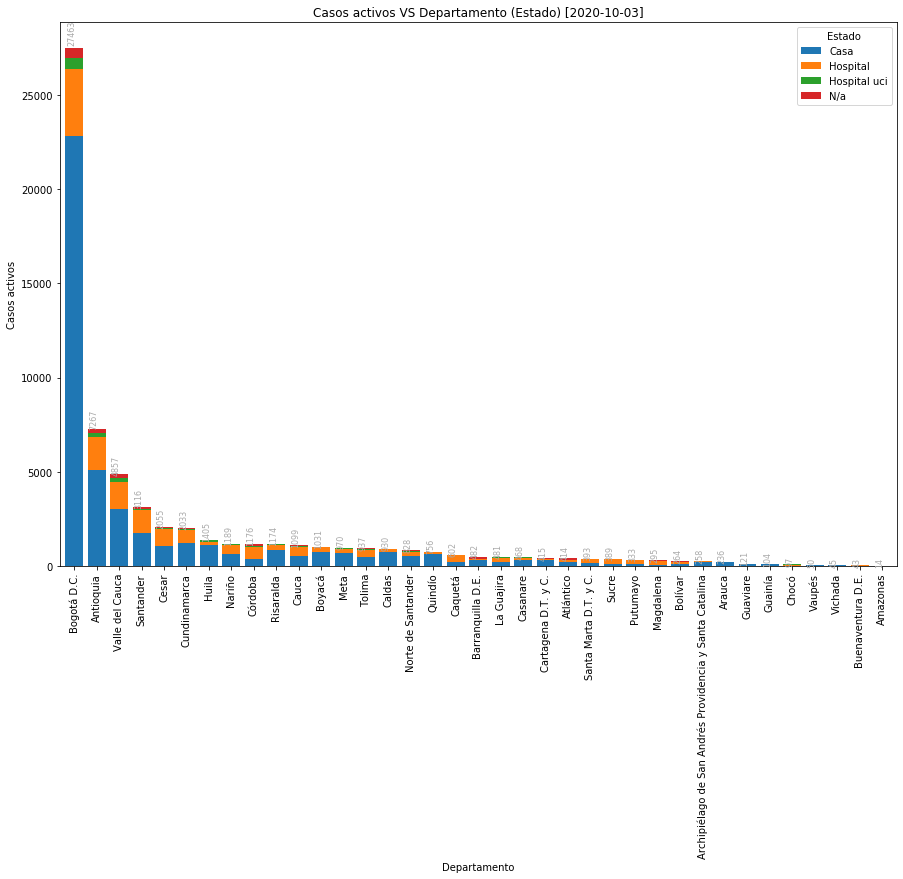

In [14]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [True, False, True, True, True, False]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos activos VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos activos')
div = len(li.columns)-1
numbers(div)

In [15]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Hospital  \
Departamento                                                            
Bogotá D.C.                                         22835.0    3544.0   
Antioquia                                            5082.0    1765.0   
Valle del Cauca                                      3047.0    1432.0   
Santander                                            1738.0    1220.0   
Cesar                                                1045.0     922.0   
Cundinamarca                                         1212.0     706.0   
Huila                                                1102.0     188.0   
Nariño                                                618.0     492.0   
Córdoba                                               390.0     647.0   
Risaralda                                             827.0     280.0   
Cauca                                                 557.0     445.0   
Boyacá                                                724.0     275.0   
Meta                                                  679.0     250.0   
Tolima                                                461.0     405.0   
Caldas                                                724.0     166.0   
Norte de Santander                                    553.0     183.0   
Quindío                                               657.0      95.0   
Caquetá                                               229.0     335.0   
Barranquilla D.E.                                     339.0      21.0   
La Guajira                                            220.0     229.0   
Casanare                                              317.0     132.0   
Cartagena D.T. y C.                                   300.0      64.0   
Atlántico                                             207.0      96.0   
Santa Marta D.T. y C.                                 156.0     200.0   
Sucre                                                 125.0     224.0   
Putumayo                                              113.0     208.0   
Magdalena                                              81.0     164.0   
Bolívar                                               127.0      93.0   
Archipiélago de San Andrés Providencia y Santa ...    225.0      28.0   
Arauca                                                207.0      26.0   
Guaviare                                              109.0       8.0   
Guainía                                                87.0      17.0   
Chocó                                                  29.0      51.0   
Vaupés                                                 44.0       4.0   
Vichada                                                37.0       7.0   
Buenaventura D.E.                                       8.0      23.0   
Amazonas                                                4.0       6.0   

Estado                                              Hospital uci    N/a  \
Departamento                                                              
Bogotá D.C.                                                589.0  495.0   
Antioquia                                                  233.0  187.0   
Valle del Cauca                                            208.0  170.0   
Santander                                                   90.0   68.0   
Cesar                                                       50.0   38.0   
Cundinamarca                                                68.0   47.0   
Huila                                                       89.0   26.0   
Nariño                                                      35.0   44.0   
Córdoba                                                     16.0  123.0   
Risaralda                                                   51.0   16.0   
Cauca                                                       63.0   34.0   
Boyacá                                                      11.0   21.0   
Meta                                                        15.0   26.0   
Tolima                     

### - Casos confirmados VS Departamento (Estado)

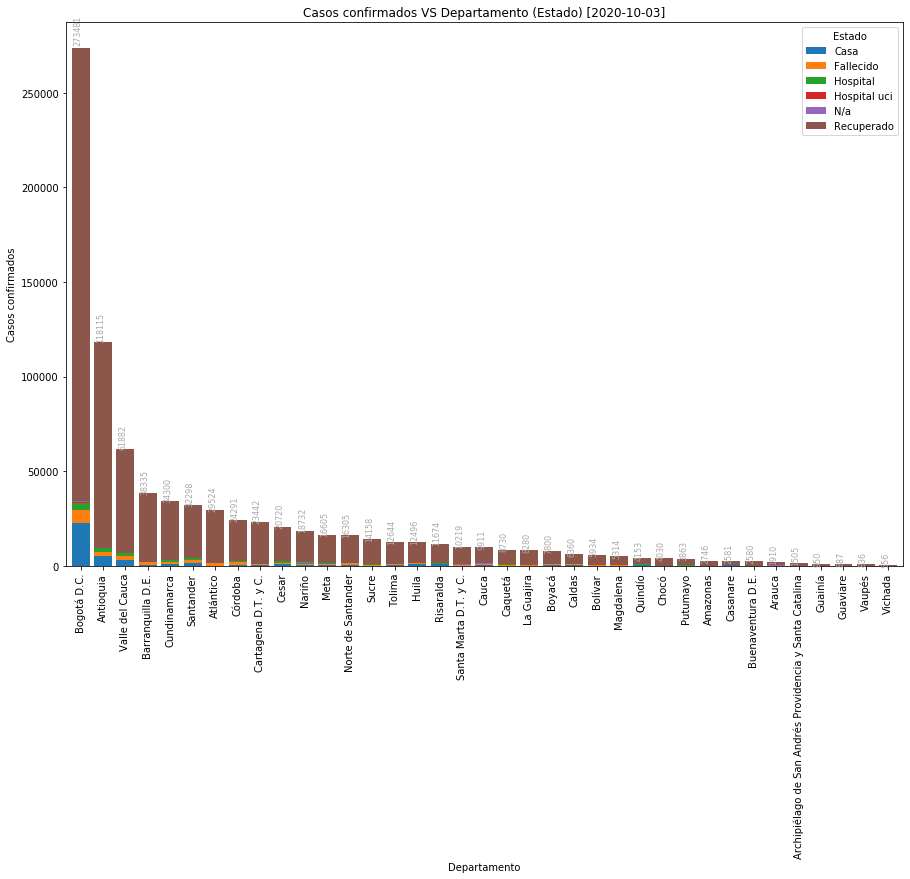

In [16]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [17]:
li.sort_values('Total', ascending=False)

Estado                                                 Casa  Fallecido  \
Departamento                                                             
Bogotá D.C.                                         22835.0     6874.0   
Antioquia                                            5082.0     2486.0   
Valle del Cauca                                      3047.0     2168.0   
Barranquilla D.E.                                     339.0     1681.0   
Cundinamarca                                         1212.0     1026.0   
Santander                                            1738.0     1351.0   
Atlántico                                             207.0     1395.0   
Córdoba                                               390.0     1554.0   
Cartagena D.T. y C.                                   300.0      555.0   
Cesar                                                1045.0      636.0   
Nariño                                                618.0      692.0   
Meta                                                  679.0      433.0   
Norte de Santander                                    553.0      920.0   
Sucre                                                 125.0      584.0   
Tolima                                                461.0      359.0   
Huila                                                1102.0      387.0   
Risaralda                                             827.0      268.0   
Santa Marta D.T. y C.                                 156.0      448.0   
Cauca                                                 557.0      278.0   
Caquetá                                               229.0      308.0   
La Guajira                                            220.0      318.0   
Boyacá                                                724.0      160.0   
Caldas                                                724.0      141.0   
Bolívar                                               127.0      228.0   
Magdalena                                              81.0      398.0   
Quindío                                               657.0      114.0   
Chocó                                                  29.0      157.0   
Putumayo                                              113.0      177.0   
Amazonas                                                4.0      117.0   
Casanare                                              317.0       51.0   
Buenaventura D.E.                                       8.0      172.0   
Arauca                                                207.0       55.0   
Archipiélago de San Andrés Providencia y Santa ...    225.0       16.0   
Guainía                                                87.0       15.0   
Guaviare                                              109.0       18.0   
Vaupés                                                 44.0       11.0   
Vichada                                                37.0        5.0   

Estado                                              Hospital  Hospital uci  \
Departamento                                                                 
Bogotá D.C.                                           3544.0         589.0   
Antioquia                                             1765.0         233.0   
Valle del Cauca                                       1432.0         208.0   
Barranquilla D.E.                                       21.0           0.0   
Cundinamarca                                           706.0          68.0   
Santander                                             1220.0          90.0   
Atlántico                                               96.0          11.0   
Córdoba                                                647.0          16.0   
Cartagena D.T. y C.                                     64.0          11.0   
Cesar                                                  922.0          50.0   
Nariño                                                 492.0          35.0   
Meta                                                   250.0          15.0   
Norte de Santander   

### - Casos confirmados VS Departamento (Sexo)

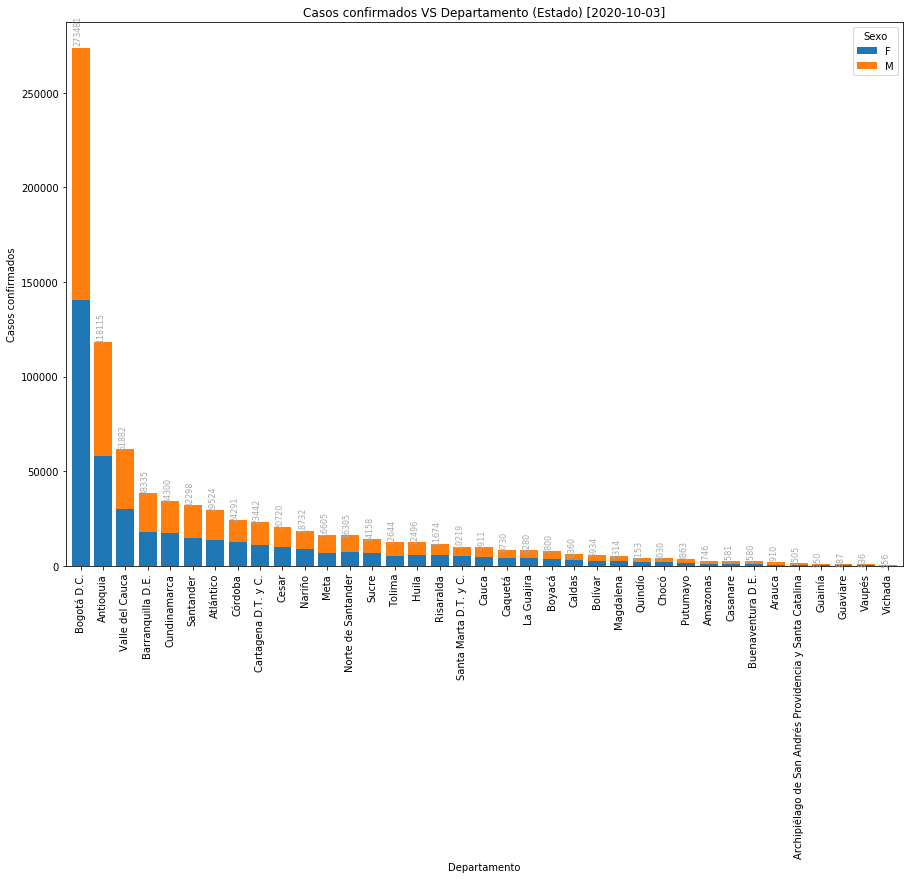

In [18]:
li = data.groupby(['Departamento', 'Sexo']).size().unstack().fillna(0)
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:, :len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Departamento (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(li.columns)-1
numbers(div)

In [19]:
li.sort_values('Total', ascending=False)

Sexo                                                     F       M   Total
Departamento                                                              
Bogotá D.C.                                         140606  132875  273481
Antioquia                                            57969   60146  118115
Valle del Cauca                                      30361   31521   61882
Barranquilla D.E.                                    18208   20127   38335
Cundinamarca                                         17463   16837   34300
Santander                                            14851   17447   32298
Atlántico                                            14014   15510   29524
Córdoba                                              12655   11636   24291
Cartagena D.T. y C.                                  11053   12389   23442
Cesar                                                10263   10457   20720
Nariño                                                9160    9572   18732
Meta                                                  6910    9695   16605
Norte de Santander                                    7673    8632   16305
Sucre                                                 7032    7126   14158
Tolima                                                5313    7331   12644
Huila                                                 6035    6461   12496
Risaralda                                             5754    5920   11674
Santa Marta D.T. y C.                                 5139    5080   10219
Cauca                                                 4927    4984    9911
Caquetá                                               4274    4456    8730
La Guajira                                            4282    3998    8280
Boyacá                                                3716    4084    7800
Caldas                                                3123    3237    6360
Bolívar                                               2845    3089    5934
Magdalena                                             2717    2597    5314
Quindío                                               2014    2139    4153
Chocó                                                 1920    2110    4030
Putumayo                                              1801    2062    3863
Amazonas                                              1184    1562    2746
Casanare                                              1063    1518    2581
Buenaventura D.E.                                      953    1627    2580
Arauca                                                 763    1147    1910
Archipiélago de San Andrés Providencia y Santa ...     790     715    1505
Guainía                                                448     502     950
Guaviare                                               351     536     887
Vaupés                                                 373     463     836
Vichada                                                204     352     556

### - Recuperados y Fallecidos VS Departamento

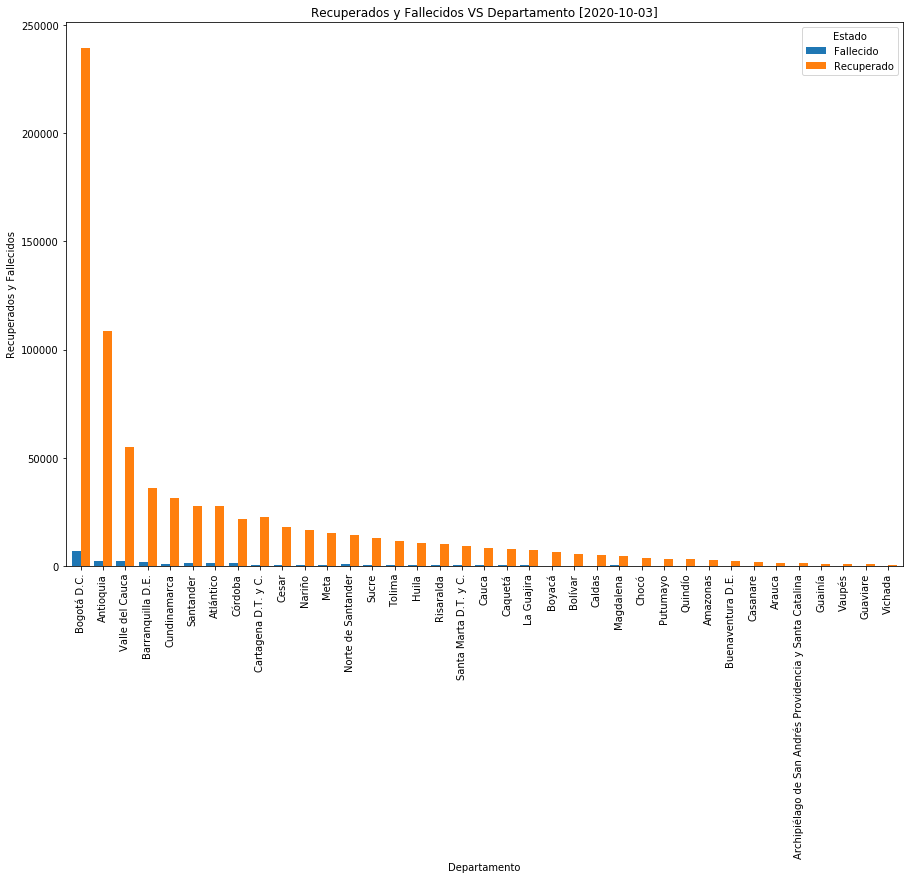

In [20]:
li = data.groupby(['Departamento', 'Estado']).size().unstack().fillna(0).iloc[:, [False, True, False, False, False, True]]
li['Total'] = li.sum(axis=1)
ax = li.sort_values('Total').iloc[:,:len(li.columns)-1][::-1].plot(kind='bar', width=0.8, stacked=False, figsize=(15,10), title=(f'Recuperados y Fallecidos VS Departamento [{date}]'))
ax.set_ylabel('Recuperados y Fallecidos')
div = len(li.columns)-1
#numbers(div)

In [21]:
li.sort_values('Total', ascending=False).iloc[:,:len(li.columns)-1]

Estado                                              Fallecido  Recuperado
Departamento                                                             
Bogotá D.C.                                            6874.0    239144.0
Antioquia                                              2486.0    108362.0
Valle del Cauca                                        2168.0     54857.0
Barranquilla D.E.                                      1681.0     36172.0
Cundinamarca                                           1026.0     31241.0
Santander                                              1351.0     27831.0
Atlántico                                              1395.0     27715.0
Córdoba                                                1554.0     21561.0
Cartagena D.T. y C.                                     555.0     22472.0
Cesar                                                   636.0     18029.0
Nariño                                                  692.0     16851.0
Meta                                                    433.0     15202.0
Norte de Santander                                      920.0     14557.0
Sucre                                                   584.0     13185.0
Tolima                                                  359.0     11348.0
Huila                                                   387.0     10704.0
Risaralda                                               268.0     10232.0
Santa Marta D.T. y C.                                   448.0      9378.0
Cauca                                                   278.0      8534.0
Caquetá                                                 308.0      7820.0
La Guajira                                              318.0      7481.0
Boyacá                                                  160.0      6609.0
Bolívar                                                 228.0      5442.0
Caldas                                                  141.0      5289.0
Magdalena                                               398.0      4621.0
Chocó                                                   157.0      3776.0
Putumayo                                                177.0      3353.0
Quindío                                                 114.0      3283.0
Amazonas                                                117.0      2615.0
Buenaventura D.E.                                       172.0      2365.0
Casanare                                                 51.0      2062.0
Arauca                                                   55.0      1619.0
Archipiélago de San Andrés Providencia y Santa ...       16.0      1231.0
Guainía                                                  15.0       831.0
Vaupés                                                   11.0       775.0
Guaviare                                                 18.0       748.0
Vichada                                                   5.0       506.0

* Fallecimientos relacionados al COVID-19.

### - Casos confirmados acumulado VS Fecha de diagnóstico (Estado)

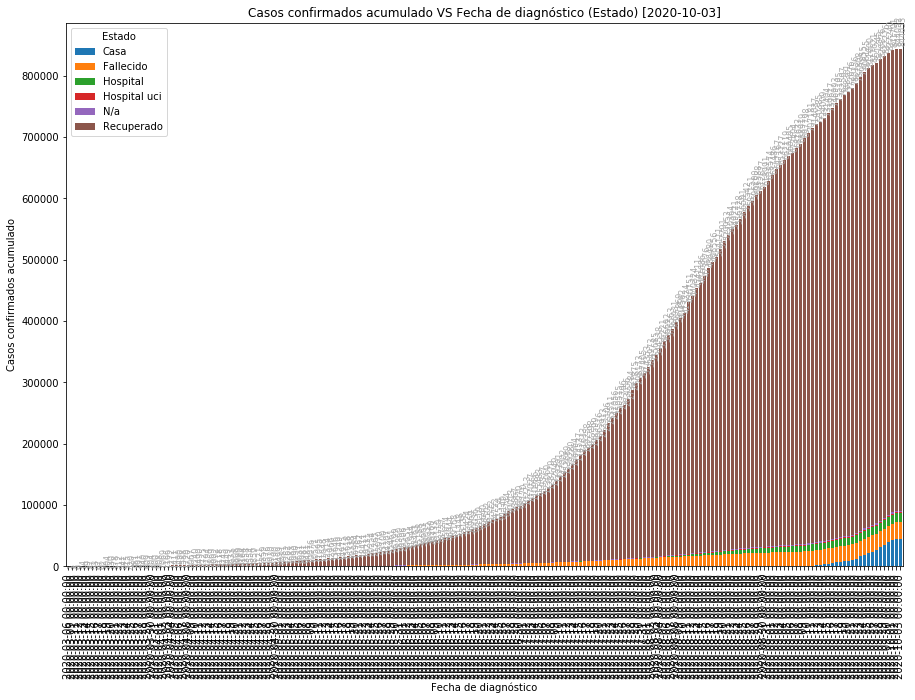

In [22]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Estado'].unique())
numbers(div)

In [23]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Estado                   Casa  Fallecido  Hospital  Hospital uci     N/a  \
Fecha de diagnóstico                                                       
2020-10-03            45215.0    26342.0   14946.0        1758.0  1837.0   
2020-10-02            45214.0    26342.0   14946.0        1758.0  1837.0   
2020-10-01            43007.0    26340.0   14813.0        1758.0  1837.0   
2020-09-30            39187.0    26320.0   14554.0        1758.0  1836.0   
2020-09-29            35164.0    26286.0   14270.0        1755.0  1836.0   
2020-09-28            30772.0    26245.0   13986.0        1752.0  1835.0   
2020-09-27            26408.0    26196.0   13712.0        1744.0  1829.0   
2020-09-26            24073.0    26164.0   13569.0        1738.0  1826.0   
2020-09-25            21319.0    26103.0   13342.0        1724.0  1823.0   
2020-09-24            19009.0    26054.0   13175.0        1716.0  1820.0   
2020-09-23            16079.0    25933.0   12762.0        1693.0  1813.0   
2020-09-22            12524.0    25799.0   12371.0        1677.0  1802.0   
2020-09-21            10669.0    25668.0   12023.0        1649.0  1797.0   
2020-09-20             9123.0    25559.0   11789.0        1641.0  1788.0   
2020-09-19             8313.0    25478.0   11608.0        1625.0  1787.0   
2020-09-18             7271.0    25365.0   11418.0        1606.0  1781.0   
2020-09-17             6378.0    25232.0   11149.0        1568.0  1769.0   
2020-09-16             5463.0    25104.0   10884.0        1530.0  1754.0   
2020-09-15             4551.0    24936.0   10623.0        1486.0  1745.0   
2020-09-14             3410.0    24792.0   10438.0        1447.0  1737.0   
2020-09-13             2455.0    24635.0   10247.0        1406.0  1723.0   
2020-09-12             2031.0    24572.0   10131.0        1387.0  1718.0   
2020-09-11             1205.0    24407.0    9966.0        1363.0  1709.0   
2020-09-10              162.0    24250.0    9759.0        1332.0  1697.0   
2020-09-09              156.0    24060.0    9469.0        1306.0  1682.0   
2020-09-08              150.0    23865.0    9197.0        1285.0  1670.0   
2020-09-07              146.0    23690.0    9002.0        1255.0  1665.0   
2020-09-06              141.0    23506.0    8786.0        1232.0  1652.0   
2020-09-05              138.0    23412.0    8683.0        1225.0  1650.0   
2020-09-04              135.0    23230.0    8341.0        1202.0  1636.0   
2020-09-03              134.0    23052.0    8191.0        1160.0  1621.0   
2020-09-02              126.0    22889.0    8014.0        1141.0  1613.0   
2020-09-01               95.0    22572.0    7837.0        1111.0  1594.0   
2020-08-31               86.0    22368.0    7666.0        1086.0  1584.0   
2020-08-30               82.0    22120.0    7404.0        1056.0  1570.0   
2020-08-29               79.0    21959.0    7224.0        1033.0  1553.0   
2020-08-28               70.0    21764.0    7036.0        1015.0  1540.0   
2020-08-27               63.0    21494.0    6755.0         973.0  1525.0   
2020-08-26               58.0    21242.0    6493.0         948.0  1508.0   
2020-08-25               58.0    20926.0    6242.0         920.0  1493.0   
2020-08-24               54.0    20646.0    5975.0         887.0  1474.0   
2020-08-23               49.0    20325.0    5695.0         864.0  1454.0   
2020-08-22               48.0    20135.0    5492.0         854.0  1444.0   
2020-08-21               48.0    19856.0    5144.0         843.0  1429.0   
2020-08-20               47.0    19544.0    4823.0         820.0  1403.0   
2020-08-19               43.0    19091.0    4401.0         785.0  1379.0   
2020-08-18               32.0    18727.0    4076.0         751.0  1353.0   
2020-08-17               32.0    18450.0    3852.0         737.0  1325.0   
2020-08-16               29.0    18230.0    3656.0         721.0  1308.0   
2020-08-15               22.0    17907.0    3357.0         698.0  1293.0   
2020-08-14               20.0    17585.0    3069

### - Casos confirmados VS Fecha de diagnóstico (Estado)

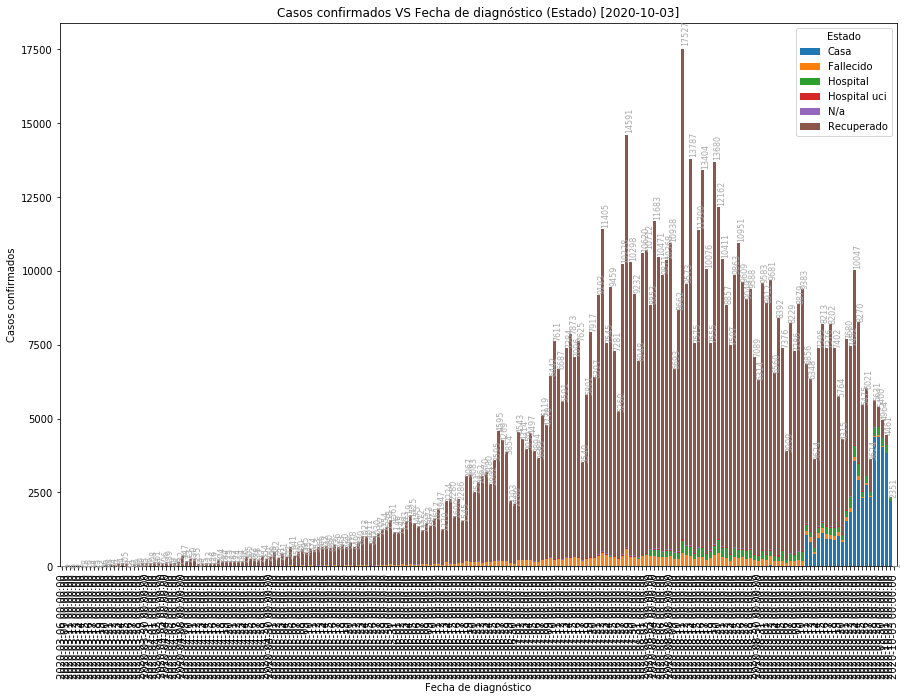

In [24]:
ax = data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Estado) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers(div)

In [25]:
data.groupby(['Fecha de diagnóstico', 'Estado']).size().unstack().fillna(0).tail(60)[::-1]

Estado                  Casa  Fallecido  Hospital  Hospital uci   N/a  \
Fecha de diagnóstico                                                    
2020-10-03               1.0        0.0       0.0           0.0   0.0   
2020-10-02            2207.0        2.0     133.0           0.0   0.0   
2020-10-01            3820.0       20.0     259.0           0.0   1.0   
2020-09-30            4023.0       34.0     284.0           3.0   0.0   
2020-09-29            4392.0       41.0     284.0           3.0   1.0   
2020-09-28            4364.0       49.0     274.0           8.0   6.0   
2020-09-27            2335.0       32.0     143.0           6.0   3.0   
2020-09-26            2754.0       61.0     227.0          14.0   3.0   
2020-09-25            2310.0       49.0     167.0           8.0   3.0   
2020-09-24            2930.0      121.0     413.0          23.0   7.0   
2020-09-23            3555.0      134.0     391.0          16.0  11.0   
2020-09-22            1855.0      131.0     348.0          28.0   5.0   
2020-09-21            1546.0      109.0     234.0           8.0   9.0   
2020-09-20             810.0       81.0     181.0          16.0   1.0   
2020-09-19            1042.0      113.0     190.0          19.0   6.0   
2020-09-18             893.0      133.0     269.0          38.0  12.0   
2020-09-17             915.0      128.0     265.0          38.0  15.0   
2020-09-16             912.0      168.0     261.0          44.0   9.0   
2020-09-15            1141.0      144.0     185.0          39.0   8.0   
2020-09-14             955.0      157.0     191.0          41.0  14.0   
2020-09-13             424.0       63.0     116.0          19.0   5.0   
2020-09-12             826.0      165.0     165.0          24.0   9.0   
2020-09-11            1043.0      157.0     207.0          31.0  12.0   
2020-09-10               6.0      190.0     290.0          26.0  15.0   
2020-09-09               6.0      195.0     272.0          21.0  12.0   
2020-09-08               4.0      175.0     195.0          30.0   5.0   
2020-09-07               5.0      184.0     216.0          23.0  13.0   
2020-09-06               3.0       94.0     103.0           7.0   2.0   
2020-09-05               3.0      182.0     342.0          23.0  14.0   
2020-09-04               1.0      178.0     150.0          42.0  15.0   
2020-09-03               8.0      163.0     177.0          19.0   8.0   
2020-09-02              31.0      317.0     177.0          30.0  19.0   
2020-09-01               9.0      204.0     171.0          25.0  10.0   
2020-08-31               4.0      248.0     262.0          30.0  14.0   
2020-08-30               3.0      161.0     180.0          23.0  17.0   
2020-08-29               9.0      195.0     188.0          18.0  13.0   
2020-08-28               7.0      270.0     281.0          42.0  15.0   
2020-08-27               5.0      252.0     262.0          25.0  17.0   
2020-08-26               0.0      316.0     251.0          28.0  15.0   
2020-08-25               4.0      280.0     267.0          33.0  19.0   
2020-08-24               5.0      321.0     280.0          23.0  20.0   
2020-08-23               1.0      190.0     203.0          10.0  10.0   
2020-08-22               0.0      279.0     348.0          11.0  15.0   
2020-08-21               1.0      312.0     321.0          23.0  26.0   
2020-08-20               4.0      453.0     422.0          35.0  24.0   
2020-08-19              11.0      364.0     325.0          34.0  26.0   
2020-08-18               0.0      277.0     224.0          14.0  28.0   
2020-08-17               3.0      220.0     196.0          16.0  17.0   
2020-08-16               7.0      323.0     299.0          23.0  15.0   
2020-08-15               2.0      322.0     288.0          18.0  14.0   
2020-08-14               2.0      259.0     168.0          12.0  15.0   
2020-08-13               1.0      341.0     326.0          28.0  25.0   
2020-08-12               1.0      387.0     285.0         

### - Casos confirmados VS Clasificación de edad (Estado)

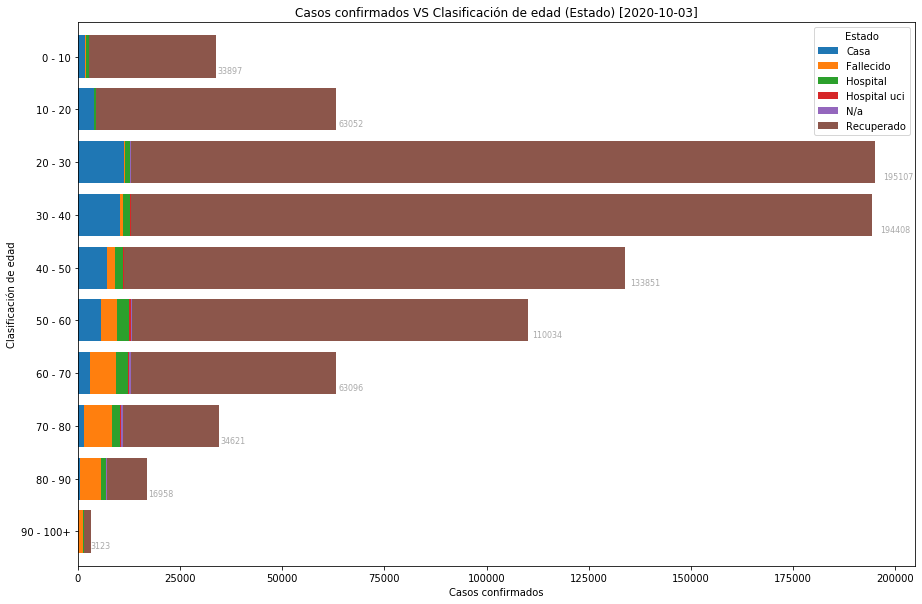

In [26]:
ax = data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Estado) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Estado'].unique())
numbers_H(div)

In [27]:
data.groupby(['Clasificación de edad', 'Estado']).size().unstack().fillna(0)

Estado                  Casa  Fallecido  Hospital  Hospital uci  N/a  \
Clasificación de edad                                                  
0 - 10                  1834         42       785            44   39   
10 - 20                 3900         47       431            16   37   
20 - 30                11187        338      1241            76   80   
30 - 40                10272        841      1705           154   73   
40 - 50                 7090       1859      2031           241  136   
50 - 60                 5753       3885      2867           418  227   
60 - 70                 3022       6354      2781           439  405   
70 - 80                 1444       6888      1974           279  430   
80 - 90                  620       5136      1000            88  351   
90 - 100+                 93       1166       136             5   86   

Estado                 Recuperado  
Clasificación de edad              
0 - 10                      31153  
10 - 20                     58621  
20 - 30                    182185  
30 - 40                    181363  
40 - 50                    122494  
50 - 60                     96884  
60 - 70                     50095  
70 - 80                     23606  
80 - 90                      9763  
90 - 100+                    1637

### - Casos confirmados acumulado VS Fecha de diagnóstico (Sexo)

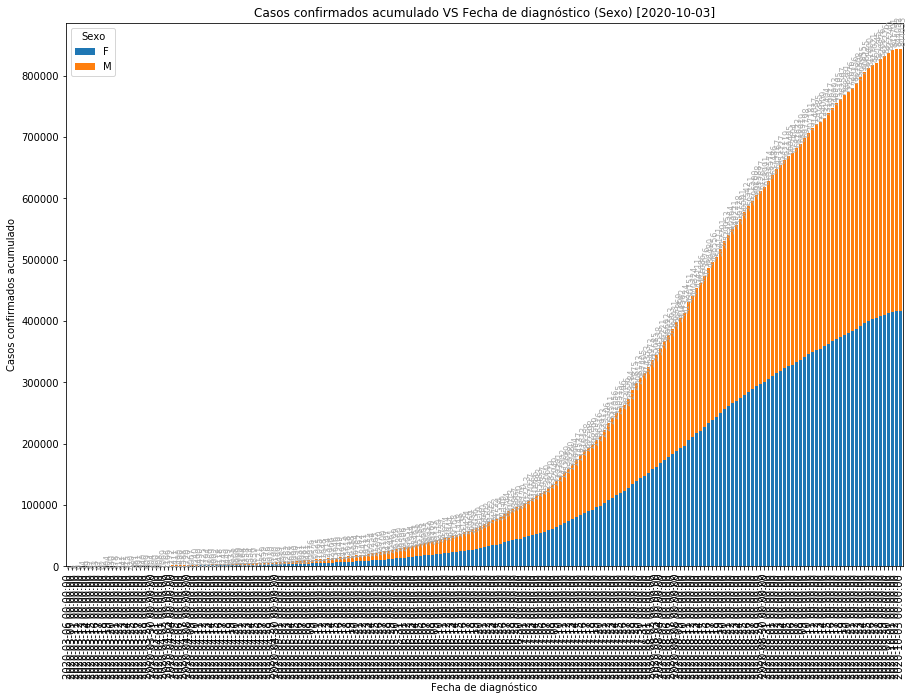

In [28]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulado VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Sexo'].unique())
numbers(div)

In [29]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Sexo                         F         M
Fecha de diagnóstico                    
2020-10-03            416252.0  427801.0
2020-10-02            416252.0  427800.0
2020-10-01            415048.0  426653.0
2020-09-30            412775.0  424465.0
2020-09-29            410256.0  422020.0
2020-09-28            407379.0  419497.0
2020-09-27            404443.0  416802.0
2020-09-26            402430.0  415191.0
2020-09-25            399339.0  412261.0
2020-09-24            396510.0  409615.0
2020-09-23            392323.0  405532.0
2020-09-22            387380.0  400428.0
2020-09-21            383541.0  396815.0
2020-09-20            379590.0  393086.0
2020-09-19            377330.0  391031.0
2020-09-18            374516.0  388081.0
2020-09-17            370663.0  384532.0
2020-09-16            366603.0  380390.0
2020-09-15            362828.0  376789.0
2020-09-14            358524.0  372880.0
2020-09-13            354749.0  369260.0
2020-09-12            352905.0  367480.0
2020-09-11            349562.0  364475.0
2020-09-10            345911.0  361270.0
2020-09-09            341122.0  356676.0
2020-09-08            336601.0  352318.0
2020-09-07            332882.0  348751.0
2020-09-06            328615.0  344789.0
2020-09-05            326614.0  342881.0
2020-09-04            323126.0  338993.0
2020-09-03            318633.0  335094.0
2020-09-02            315282.0  331885.0
2020-09-01            310336.0  327150.0
2020-08-31            305873.0  322701.0
2020-08-30            300827.0  318164.0
2020-08-29            297627.0  315050.0
2020-08-28            294044.0  311544.0
2020-08-27            289325.0  306875.0
2020-08-26            284758.0  302393.0
2020-08-25            279862.0  297680.0
2020-08-24            274362.0  292229.0
2020-08-23            269443.0  287285.0
2020-08-22            265644.0  283577.0
2020-08-21            261471.0  278893.0
2020-08-20            256221.0  273732.0
2020-08-19            250088.0  267703.0
2020-08-18            242949.0  261162.0
2020-08-17            239301.0  257255.0
2020-08-16            233982.0  252498.0
2020-08-15            226971.0  246105.0
2020-08-14            221190.0  240496.0
2020-08-13            217312.0  236799.0
2020-08-12            210419.0  229905.0
2020-08-11            205674.0  225077.0
2020-08-10            196594.0  216630.0
2020-08-09            192250.0  212312.0
2020-08-08            188792.0  209077.0
2020-08-07            183463.0  203468.0
2020-08-06            178400.0  198163.0
2020-08-05            173512.0  193180.0

### - Casos confirmados VS Fecha de diagnóstico (Sexo)

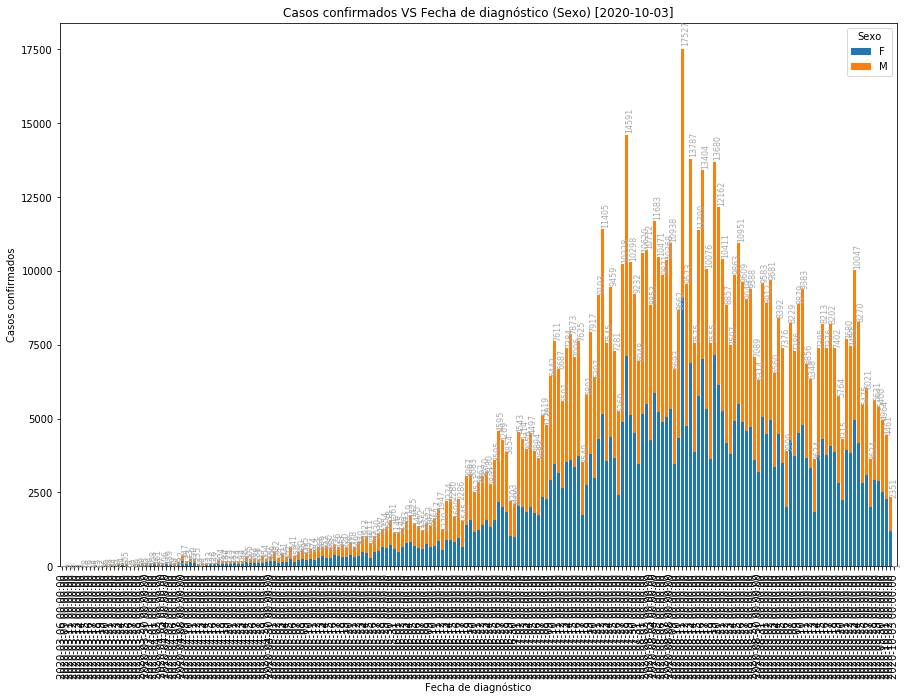

In [30]:
ax = data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Sexo) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers(div)

In [31]:
data.groupby(['Fecha de diagnóstico', 'Sexo']).size().unstack().fillna(0).tail(60)[::-1]

Sexo                       F       M
Fecha de diagnóstico                
2020-10-03               0.0     1.0
2020-10-02            1204.0  1147.0
2020-10-01            2273.0  2188.0
2020-09-30            2519.0  2445.0
2020-09-29            2877.0  2523.0
2020-09-28            2936.0  2695.0
2020-09-27            2013.0  1611.0
2020-09-26            3091.0  2930.0
2020-09-25            2829.0  2646.0
2020-09-24            4187.0  4083.0
2020-09-23            4943.0  5104.0
2020-09-22            3839.0  3613.0
2020-09-21            3951.0  3729.0
2020-09-20            2260.0  2055.0
2020-09-19            2814.0  2950.0
2020-09-18            3853.0  3549.0
2020-09-17            4060.0  4142.0
2020-09-16            3775.0  3601.0
2020-09-15            4304.0  3909.0
2020-09-14            3775.0  3620.0
2020-09-13            1844.0  1780.0
2020-09-12            3343.0  3005.0
2020-09-11            3651.0  3205.0
2020-09-10            4789.0  4594.0
2020-09-09            4521.0  4358.0
2020-09-08            3719.0  3567.0
2020-09-07            4267.0  3962.0
2020-09-06            2001.0  1908.0
2020-09-05            3488.0  3888.0
2020-09-04            4493.0  3899.0
2020-09-03            3351.0  3209.0
2020-09-02            4946.0  4735.0
2020-09-01            4463.0  4449.0
2020-08-31            5046.0  4537.0
2020-08-30            3200.0  3114.0
2020-08-29            3583.0  3506.0
2020-08-28            4719.0  4669.0
2020-08-27            4567.0  4482.0
2020-08-26            4896.0  4713.0
2020-08-25            5500.0  5451.0
2020-08-24            4919.0  4944.0
2020-08-23            3799.0  3708.0
2020-08-22            4173.0  4684.0
2020-08-21            5250.0  5161.0
2020-08-20            6133.0  6029.0
2020-08-19            7139.0  6541.0
2020-08-18            3648.0  3907.0
2020-08-17            5319.0  4757.0
2020-08-16            7011.0  6393.0
2020-08-15            5781.0  5609.0
2020-08-14            3878.0  3697.0
2020-08-13            6893.0  6894.0
2020-08-12            4745.0  4828.0
2020-08-11            9080.0  8447.0
2020-08-10            4344.0  4318.0
2020-08-09            3458.0  3235.0
2020-08-08            5329.0  5609.0
2020-08-07            5063.0  5305.0
2020-08-06            4888.0  4983.0
2020-08-05            5238.0  5233.0

### - Casos confirmados VS Clasificación de edad (Sexo)

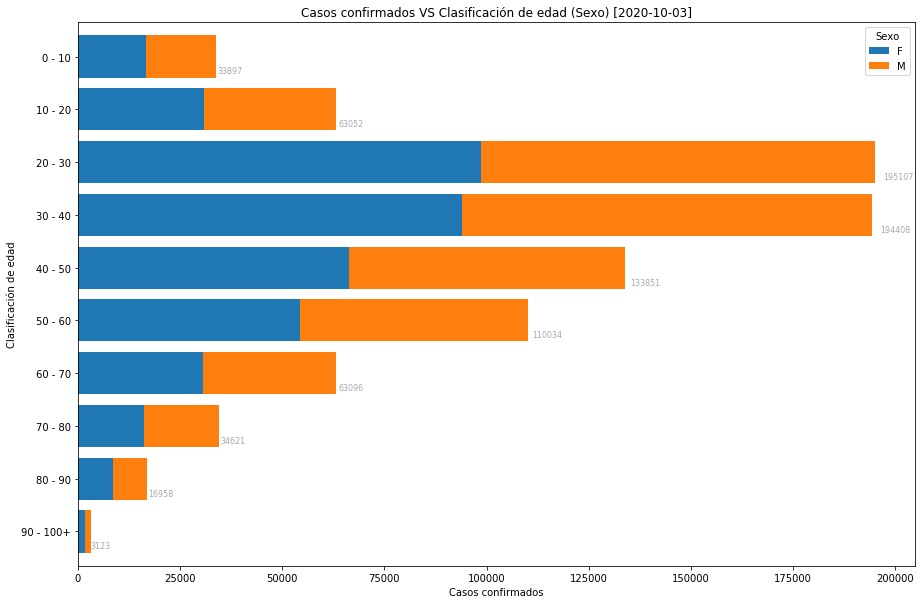

In [32]:
ax = data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Clasificación de edad (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [33]:
data.groupby(['Clasificación de edad', 'Sexo']).size().unstack().fillna(0)

Sexo                       F       M
Clasificación de edad               
0 - 10                 16549   17348
10 - 20                30866   32186
20 - 30                98614   96493
30 - 40                94079  100329
40 - 50                66395   67456
50 - 60                54350   55684
60 - 70                30633   32463
70 - 80                16270   18351
80 - 90                 8684    8274
90 - 100+               1767    1356

### - Casos confirmados VS Estado (Sexo)

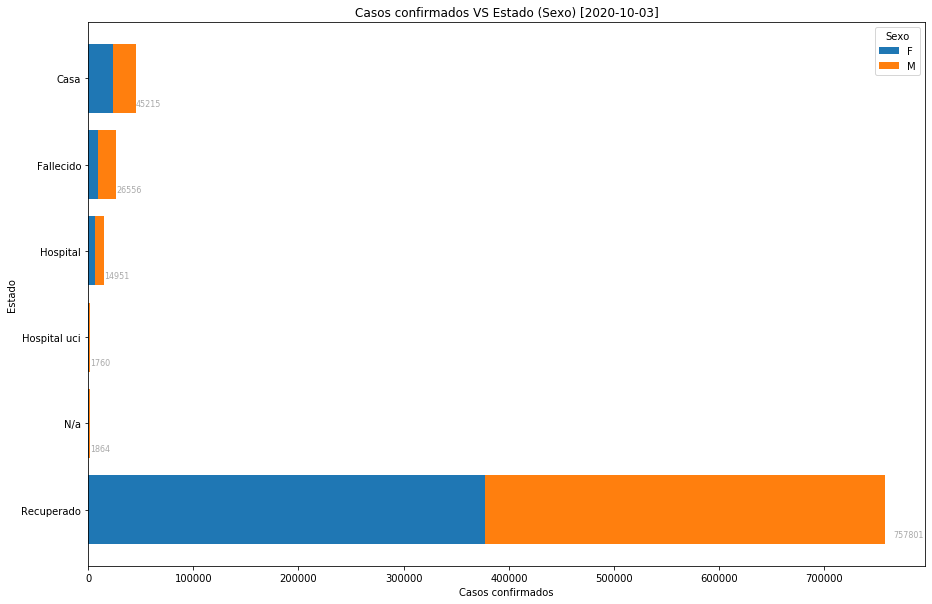

In [34]:
ax = data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [35]:
data.groupby(['Estado', 'Sexo']).size().unstack().fillna(0)

Sexo               F       M
Estado                      
Casa           23869   21346
Fallecido       9515   17041
Hospital        6502    8449
Hospital uci     602    1158
N/a              798    1066
Recuperado    376921  380880

### - Casos confirmados VS Tipo de contagio (Sexo)

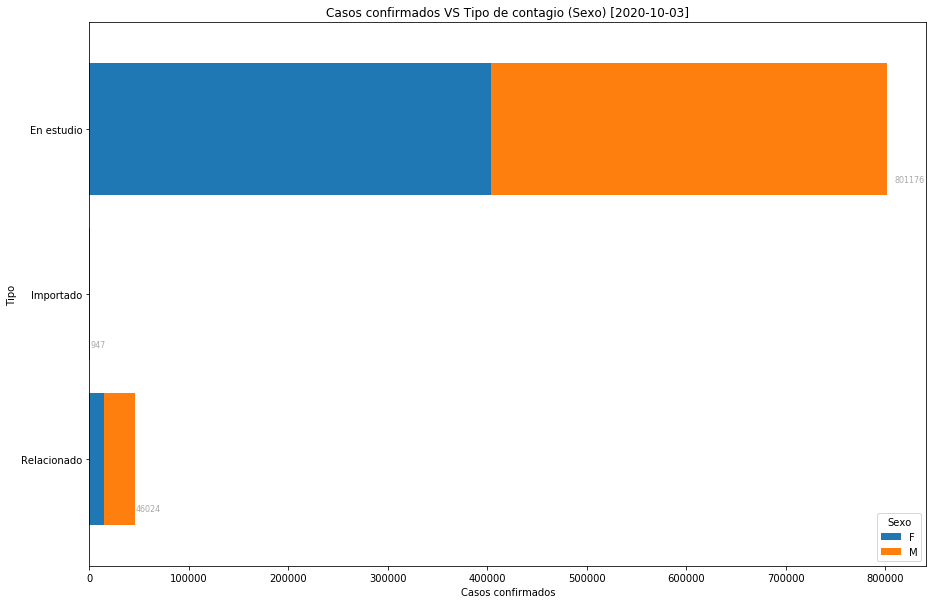

In [36]:
ax = data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo de contagio (Sexo) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Sexo'].unique())
numbers_H(div)

In [37]:
data.groupby(['Tipo', 'Sexo']).size().unstack().fillna(0)

Sexo              F       M
Tipo                       
En estudio   403221  397955
Importado       441     506
Relacionado   14545   31479

### - Casos confirmados acumulado VS Fecha de diagnóstico (Clasificación de edad)

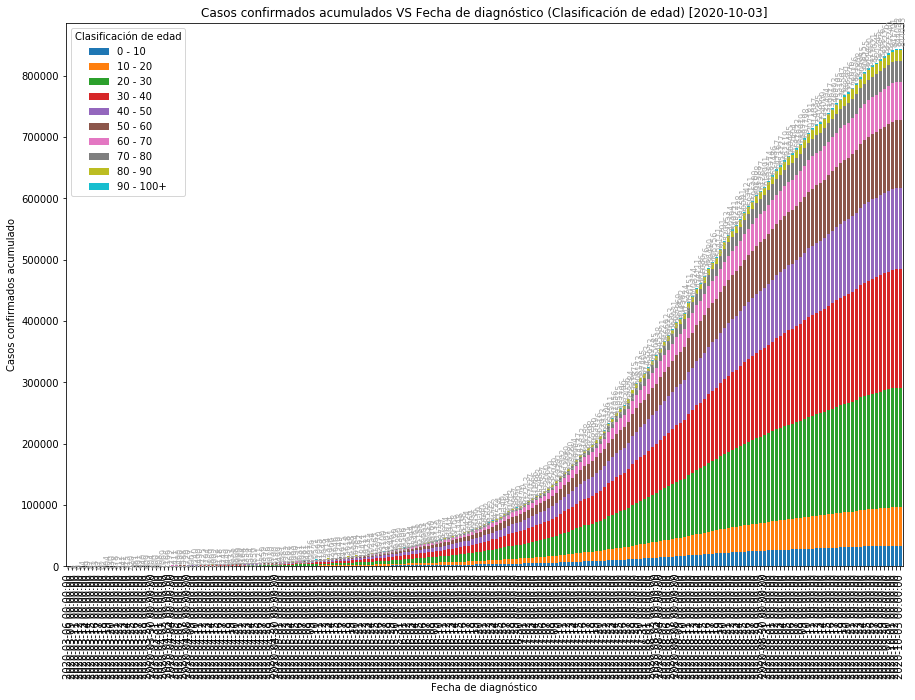

In [38]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados acumulados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados acumulado')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [39]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).cumsum().tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-10-03              33754    62759   194110   193416   133249   109535   
2020-10-02              33754    62759   194110   193416   133249   109535   
2020-10-01              33698    62599   193593   192950   132838   109201   
2020-09-30              33540    62277   192580   191916   132159   108607   
2020-09-29              33386    61881   191369   190782   131401   107965   
2020-09-28              33209    61437   190146   189595   130576   107250   
2020-09-27              32987    61003   188788   188322   129734   106535   
2020-09-26              32827    60729   188042   187544   129154   106029   
2020-09-25              32629    60258   186706   186170   128191   105277   
2020-09-24              32434    59850   185334   185018   127337   104559   
2020-09-23              32188    59309   183748   183209   125886   103340   
2020-09-22              31761    58425   180993   180885   124591   102222   
2020-09-21              31451    57859   179216   179257   123488   101315   
2020-09-20              31200    57283   177393   177517   122282   100329   
2020-09-19              31031    56974   176453   176564   121599    99766   
2020-09-18              30810    56508   175122   175295   120737    99000   
2020-09-17              30528    55975   173461   173554   119599    98027   
2020-09-16              30252    55396   171497   171694   118333    96891   
2020-09-15              29958    54879   169801   170014   117147    95909   
2020-09-14              29660    54199   167971   168100   115807    94879   
2020-09-13              29376    53673   166282   166343   114624    93945   
2020-09-12              29241    53433   165409   165477   114073    93478   
2020-09-11              28986    52861   163946   164097   113055    92693   
2020-09-10              28759    52429   162769   162536   111798    91596   
2020-09-09              28378    51704   160377   160307   110467    90462   
2020-09-08              28061    51056   158265   158162   109068    89307   
2020-09-07              27800    50519   156610   156494   107941    88383   
2020-09-06              27493    49914   154752   154661   106610    87299   
2020-09-05              27355    49637   153888   153760   105989    86812   
2020-09-04              27081    48979   152185   152078   104845    85909   
2020-09-03              26750    48444   150235   150159   103521    84796   
2020-09-02              26514    47957   148684   148684   102464    83918   
2020-09-01              26124    47295   146520   146530   100954    82641   
2020-08-31              25778    46593   144461   144493    99577    81469   
2020-08-30              25356    45876   142171   142349    98051    80284   
2020-08-29              25110    45403   140684   140921    97058    79477   
2020-08-28              24852    44867   139024   139366    95951    78514   
2020-08-27              24524    44237   136923   137159    94466    77249   
2020-08-26              24166    43582   134817   135086    93018    76084   
2020-08-25              23813    42862   132746   132895    91470    74876   
2020-08-24              23417    42148   130261   130319    89700    73413   
2020-08-23              23051    41427   127976   128093    88152    72138   
2020-08-22              22740    40819   126189   126350    87040    71147   
2020-08-21              22416    40157   124148   124245    85706    70023   
2020-08-20              21991    39406   121677   121876    84059    68659   
2020-08-19              21503    38543   119005   119144    82130    67032   
2020-08-18              20871    37543   115927   116095    79880    65296   
2020-08-17              20616    37027   114248   114386    78675    64261   
2020-08-16              20100    36263   112011   112263    77067    62911   
2020-08-15            

### - Casos confirmados VS Fecha de diagnóstico (Clasificación de edad)

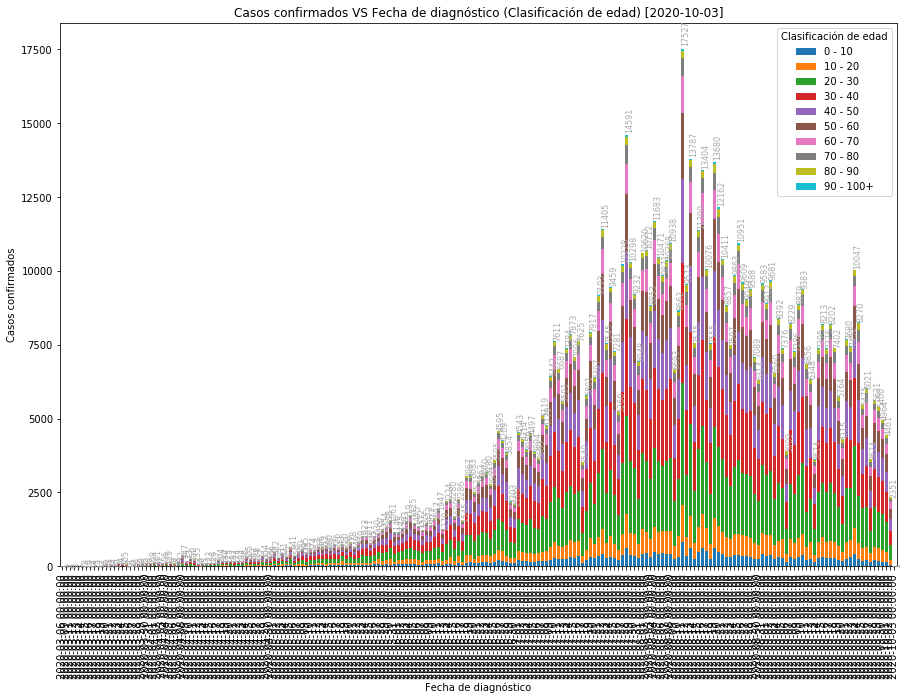

In [40]:
ax = data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).plot(kind='bar', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Fecha de diagnóstico (Clasificación de edad) [{date}]'))
ax.set_ylabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers(div)

In [41]:
data.groupby(['Fecha de diagnóstico', 'Clasificación de edad']).size().unstack().fillna(0).tail(60)[::-1]

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Fecha de diagnóstico                                                         
2020-10-03                  0        0        0        0        0        0   
2020-10-02                 56      160      517      466      411      334   
2020-10-01                158      322     1013     1034      679      594   
2020-09-30                154      396     1211     1134      758      642   
2020-09-29                177      444     1223     1187      825      715   
2020-09-28                222      434     1358     1273      842      715   
2020-09-27                160      274      746      778      580      506   
2020-09-26                198      471     1336     1374      963      752   
2020-09-25                195      408     1372     1152      854      718   
2020-09-24                246      541     1586     1809     1451     1219   
2020-09-23                427      884     2755     2324     1295     1118   
2020-09-22                310      566     1777     1628     1103      907   
2020-09-21                251      576     1823     1740     1206      986   
2020-09-20                169      309      940      953      683      563   
2020-09-19                221      466     1331     1269      862      766   
2020-09-18                282      533     1661     1741     1138      973   
2020-09-17                276      579     1964     1860     1266     1136   
2020-09-16                294      517     1696     1680     1186      982   
2020-09-15                298      680     1830     1914     1340     1030   
2020-09-14                284      526     1689     1757     1183      934   
2020-09-13                135      240      873      866      551      467   
2020-09-12                255      572     1463     1380     1018      785   
2020-09-11                227      432     1177     1561     1257     1097   
2020-09-10                381      725     2392     2229     1331     1134   
2020-09-09                317      648     2112     2145     1399     1155   
2020-09-08                261      537     1655     1668     1127      924   
2020-09-07                307      605     1858     1833     1331     1084   
2020-09-06                138      277      864      901      621      487   
2020-09-05                274      658     1703     1682     1144      903   
2020-09-04                331      535     1950     1919     1324     1113   
2020-09-03                236      487     1551     1475     1057      878   
2020-09-02                390      662     2164     2154     1510     1277   
2020-09-01                346      702     2059     2037     1377     1172   
2020-08-31                422      717     2290     2144     1526     1185   
2020-08-30                246      473     1487     1428      993      807   
2020-08-29                258      536     1660     1555     1107      963   
2020-08-28                328      630     2101     2207     1485     1265   
2020-08-27                358      655     2106     2073     1448     1165   
2020-08-26                353      720     2071     2191     1548     1208   
2020-08-25                396      714     2485     2576     1770     1463   
2020-08-24                366      721     2285     2226     1548     1275   
2020-08-23                311      608     1787     1743     1112      991   
2020-08-22                324      662     2041     2105     1334     1124   
2020-08-21                425      751     2471     2369     1647     1364   
2020-08-20                488      863     2672     2732     1929     1627   
2020-08-19                632     1000     3078     3049     2250     1736   
2020-08-18                255      516     1679     1709     1205     1035   
2020-08-17                516      764     2237     2123     1608     1350   
2020-08-16                619     1144     2980     2918     2135     1769   
2020-08-15            

### - Casos confirmados VS Estado (Clasificación de edad)

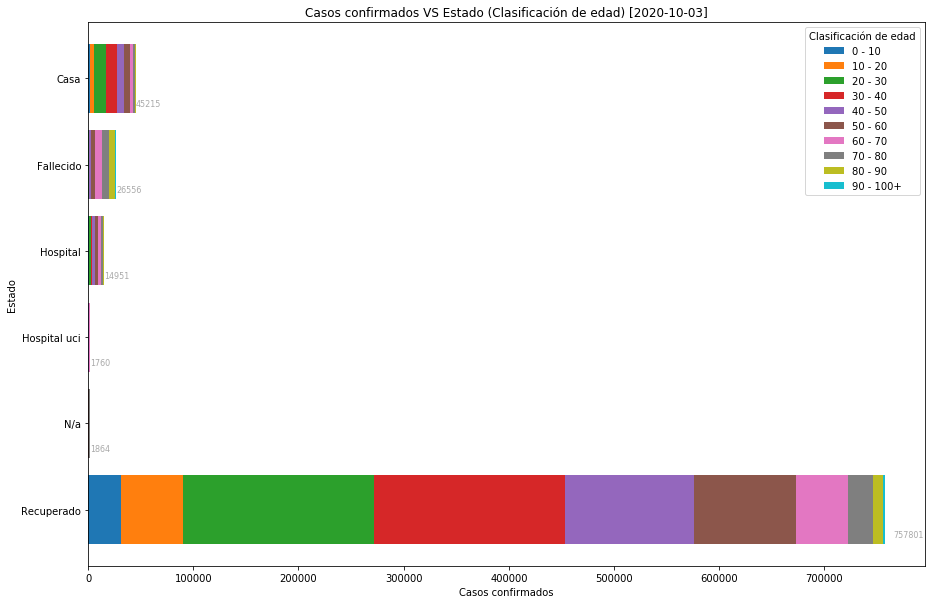

In [42]:
ax = data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Estado (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [43]:
data.groupby(['Estado', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Estado                                                                       
Casa                     1834     3900    11187    10272     7090     5753   
Fallecido                  42       47      338      841     1859     3885   
Hospital                  785      431     1241     1705     2031     2867   
Hospital uci               44       16       76      154      241      418   
N/a                        39       37       80       73      136      227   
Recuperado              31153    58621   182185   181363   122494    96884   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Estado                                                       
Casa                      3022     1444      620         93  
Fallecido                 6354     6888     5136       1166  
Hospital                  2781     1974     1000        136  
Hospital uci               439      279       88          5  
N/a                        405      430      351         86  
Recuperado               50095    23606     9763       1637

### - Casos confirmados VS Tipo de contagio (Clasificación de edad)

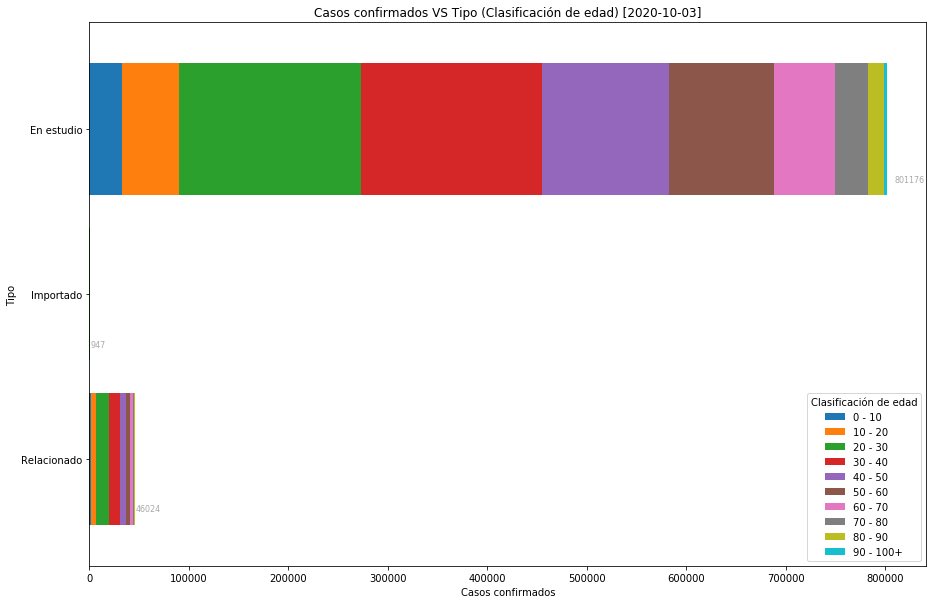

In [44]:
ax = data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0).sort_index(ascending=False).plot(kind='barh', width=0.8, stacked=True, figsize=(15,10), title=(f'Casos confirmados VS Tipo (Clasificación de edad) [{date}]'))
ax.set_xlabel('Casos confirmados')
div = len(data['Clasificación de edad'].unique())
numbers_H(div)

In [45]:
data.groupby(['Tipo', 'Clasificación de edad']).size().unstack().fillna(0)

Clasificación de edad  0 - 10  10 - 20  20 - 30  30 - 40  40 - 50  50 - 60  \
Tipo                                                                         
En estudio              32497    57800   182263   182319   127758   105773   
Importado                   6       33      235      221      163      145   
Relacionado              1394     5219    12609    11868     5930     4116   

Clasificación de edad  60 - 70  70 - 80  80 - 90  90 - 100+  
Tipo                                                         
En estudio               60766    33258    15920       2822  
Importado                   96       37       10          1  
Relacionado               2234     1326     1028        300

## #StayHome 🏠 #QuédateEnCasa
## #WearMask 😷 #UsaMascarilla 

### Creado con ❤️ por <a href='https://github.com/jlcadavid'>@jlcadavid</a>

In [46]:
# Data storage
data.to_csv(f'./Datasets/COVID-19 Status (Colombia) [{date}].csv', index = True)